# Simultaneous Fitting of a Transit with Stellar Variability

In [2]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


(3350.0, 3410.0)

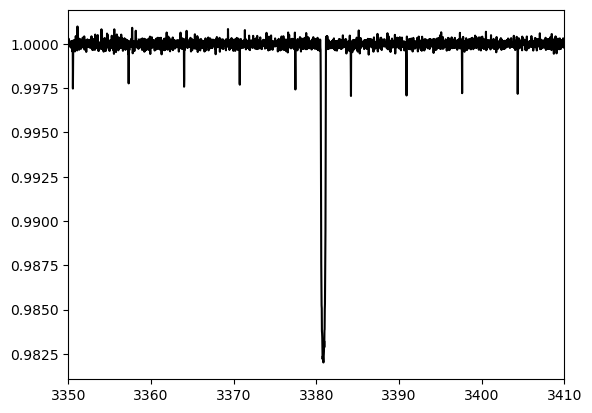

In [4]:
df = pd.read_csv('/Users/tuca/Desktop/EPIC_exoplanet_research_2023/detrended_lc.csv', header = 0,
                 names = ['time', 'flux', 'flux_error', 'Kepler'])

time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['flux_error'].values

plt.plot(time, flux, 'k')
plt.xlim(3350, 3410)


In [32]:
periods = [6.7252337648, 1000]
period_error = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = False

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

#pdb.set_trace()

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
    m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
    # deterministic means values that were derived from the model
    density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega, m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
    
    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar)
    
    ### Calculates lc for each planet at its time vector ###
    light_curves = star.get_light_curve(orbit=orbit, r=r_pl, t=time, 
                                        texp = 29.4*u.min.to('d'))
    
    ### Saves the individual lightcurves ###
    pm.Deterministic("light_curves", light_curves) 
    
    ### Full photometric model, the sum of all transits + the baseline (mean) ###
    lc_model = mean + tt.sum(light_curves, axis=-1)
    
#     # The likelihood function assuming known Gaussian uncertainty
#     pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)

    
##################################################### GP MODEL ##################################################
##################################################### GP MODEL ##################################################
    # The mean flux of the time series

    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu = np.mean(flux_error), sigma=2.0)

    # A term to describe the non-periodic variability
#     sigma = pm.InverseGamma(
#         "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
#     )
#     rho = pm.InverseGamma(
#         "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
#     )

    # The Parameters of the RotationTerm Kernel 
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    prot = pm.Normal("prot", mu = 7.42, sigma = 2.0)
    Q0 = pm.Normal("Q0", mu = np.exp(0), sigma = np.exp(2))
    #log_Q0 = pm.Normal("log_Q0", sigma=2.0)
    dQ = pm.Normal("dQ", mu = np.exp(0), sigma = np.exp(2))
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    #kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q = 1 / 3.0)
    kernel = terms.RotationTerm(
        sigma = sigma_rot,
        period = prot,
        Q0 = Q0,
        dQ = dQ,
        f = f,
    )
    gp = GaussianProcess(
        kernel,
        t = time,
        diag = flux_error**2 + tt.exp(2 * jitter),
        mean = mean,
        quiet = True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("transit_obs", observed = flux - lc_model)

    # Compute the GP model prediction for plotting purposes
    pm.Deterministic("gp_pred", gp.predict(flux - lc_model))
    
    # Optimize the MAP solution.
    map_soln = model.test_point
    print(model.check_test_point())

        
    ### Optimizing GP model ###
    map_soln = pmx.optimize(vars=[sigma_rot, f, prot, Q0, dQ])
        
    ### Optimizing LC model
    map_soln = pmx.optimize(
        vars=[
            ror,
            b,
            t0,
            period,
            r_star,
            ustar,
            mean,
        ],
    )
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)
        
    map_soln = pmx.optimize(map_soln)


mean                   -1.42
u_quadlimbdark__       -2.77
m_star_interval__      -1.12
r_star_interval__       0.01
teff_interval__        -7.10
ror_interval__         -2.77
m_pl_interval__       -20.83
period                 -5.75
t0                      2.77
b_interval__           -2.77
jitter                 -1.61
sigma_rot_log__         0.11
prot                   -1.61
Q0                     -2.92
dQ                     -2.92
f_interval__           -1.39
transit_obs         -6661.72
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [dQ, Q0, prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: -6713.807035131039 -> -6317.3898972181605
optimizing logp for variables: [mean, u, r_star, period, t0, b, ror]


message: Optimization terminated successfully.
logp: -6713.807035131039 -> -6682.503560917327
optimizing logp for variables: [f, dQ, Q0, prot, sigma_rot, jitter, b, t0, period, m_pl, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6682.503560917327 -> 43543.688674096375


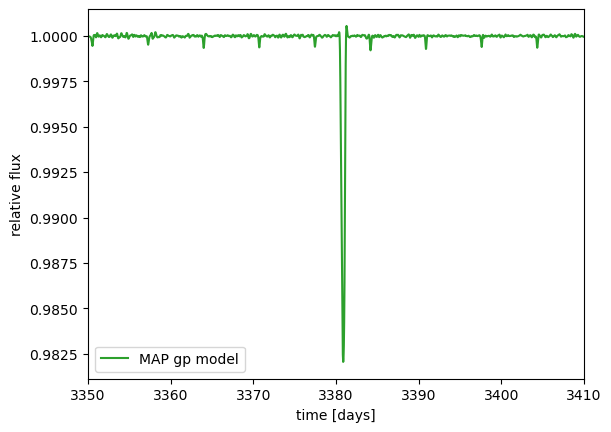

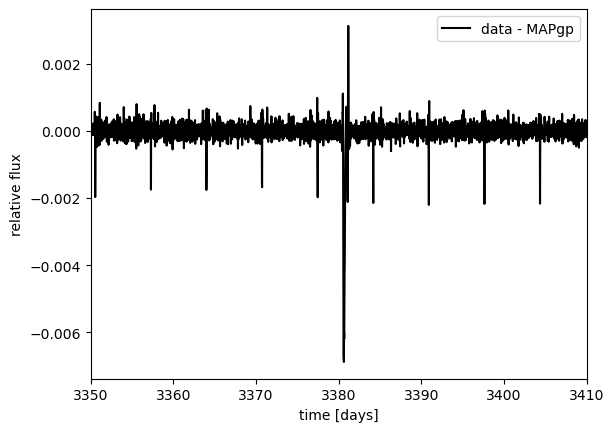

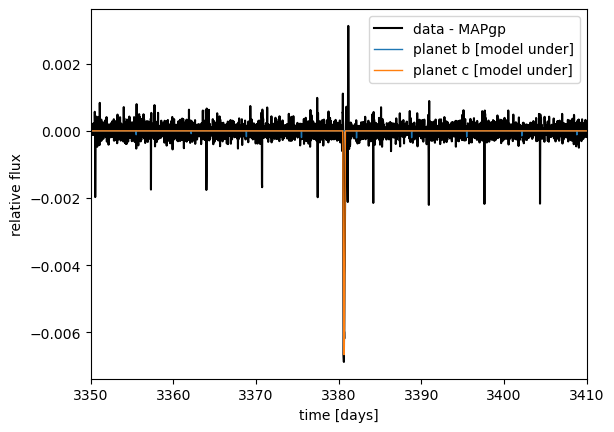

In [37]:
gp_mod = map_soln["gp_pred"] + map_soln["mean"]

plt.figure()
#plt.errorbar(time, flux, yerr = flux_error, color = 'k', marker = ".", linestyle = 'none', ms=4, label="data")
plt.plot(time, gp_mod, color="C2", label="MAP gp model")
# for i, l in enumerate("bc"):
#     plt.plot(
#         time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
#     )
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time, flux - gp_mod, "k", label="data - MAPgp")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

plt.figure()
    plt.plot(time, flux - gp_mod, "k", label="data - MAPgp")

for i, l in enumerate("bc"):
    mod = map_soln["light_curves"][:, i]
    plt.plot(time, mod, lw = 1, label="planet {0} [model under]".format(l))
    
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

IndexError: too many indices for array

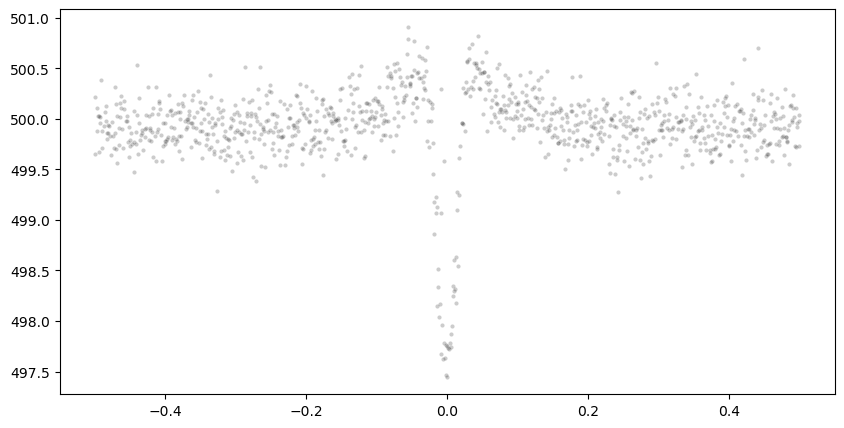

In [42]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))

period = 6.7252337648

t0 = 2457221.8349184883 - 2454833 #[2388.835, 3380.822]



x_fold = (time - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (flux[m] - map_soln["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.2,
    linewidths=0,
)

lc_mod = lc_model[:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights= flux - map_soln["gp_pred"])
denom[num == 0] = 1.0
ax.scatter(
    0.5 * (bins[1:] + bins[:-1]),
    1e3 * num / denom,
    color="C1",
    zorder=2,
    linewidths=0,
)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-3, 0.5)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [43]:
lc_model

Elemwise{add,no_inplace}.0

Nice! The phase-folded light curve shows the transit at much higher signal to noise. The data even seems like they might be asymmetric, but it'd require a lot more work to see whether or not that's robust.

Taking a look at some of the MAP parameters:

In [8]:
params = (
    "mean,logg_star,r_star,period,t0,log_depth,b,log_jitter,log_prot"
    ",log_Q0,log_dQ,r_star,rho_star,depth,ror,sigma_rot,prot,f,r_planet".split(
        ","
    )
)
for p in params:
    print(f"{p}: {map_estimate[p]:.5f}")

mean: -0.00024
logg_star: 4.52564
r_star: 0.88128
period: 7.20280
t0: 120.79044
log_depth: -6.33775
b: 0.53729
log_jitter: -8.03477
log_prot: 0.97783
log_Q0: -0.32691
log_dQ: 7.70413
r_star: 0.88128
rho_star: 1.95717
depth: 0.00177
ror: 0.03979
sigma_rot: 0.06962
prot: 2.65867
f: 0.01009
r_planet: 0.34125


Things look about right.  The planet is about $3.9 R_\oplus$, on a close-in orbit.  It's worth noting that the MAP value of $f$, the mixing fraction between the two frequencies in the `RotationTerm` kernel, favors a value so low to the bottom of our prior.   Also, we should check whether our jitter makes sense:

In [9]:
print(f"jitter is {np.exp(map_estimate['log_jitter'])*1e3:.2f} ppt")
print(f"mean(yerr) is {np.mean(yerr)*1e3:.2f} ppt")

jitter is 0.32 ppt
mean(yerr) is 0.11 ppt


So the jitter will inflate the uncertainties by around a factor of three.  If this is a concern, sigma-clipping to remove outliers as in the {ref}`tess` case study might be worthwhile.

# Sampling

Finally, we can of course go on to sample.  This takes a few hours to convergence on a typical MacBook, and so to keep this notebook from requiring lots of resources, by default we won't do it.

In [10]:
import platform
import arviz as az

# Change this to "1" if you wish to run it.
RUN_THE_SAMPLING = 0

if RUN_THE_SAMPLING:
    with model:
        trace = pm.sample(
            tune=1500,
            draws=1000,
            start=map_estimate,
            # Parallel sampling runs poorly or crashes on macos
            cores=1 if platform.system() == "Darwin" else 2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
            random_seed=[261136679, 261136680],
            init="adapt_full",
        )

    az.summary(
        trace,
        var_names=[
            "mean",
            "logg_star",
            "r_star",
            "t0",
            "period",
            "b",
            "u_star",
            "log_depth",
            "depth",
            "ecc",
            "omega",
            "log_jitter",
            "sigma_rot",
            "log_prot",
            "log_Q0",
            "log_dQ",
            "f",
            "r_planet",
        ],
    )